In [44]:
%matplotlib widget

from extractor import ViTExtractor
from dino_vit_features_paper import chunk_cosine_sim

from PIL import Image
import torch 
import numpy as np
import matplotlib.pyplot as plt

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
extractor = ViTExtractor(model_type="dino_vits8", stride=4, device="cuda")

num_patches1, load_size1 = extractor.num_patches, extractor.load_size



Using cache found in /home/tlips/.cache/torch/hub/facebookresearch_dino_main


In [46]:
source_image_path = "/home/tlips/Code/few-shot-keypoints/few_shot_keypoints/dino_vit_feature_paper/images/shoe-kil/shoe-1-2.png"
source_image_path = "/home/tlips/Code/few-shot-keypoints/few_shot_keypoints/dino_vit_feature_paper/images/shoe-kil-1/shoe-1.png"


target_image_path = "/home/tlips/Code/few-shot-keypoints/few_shot_keypoints/dino_vit_feature_paper/images/shoe-kil/shoe1-3.png"
target_image_path = "/home/tlips/Code/few-shot-keypoints/few_shot_keypoints/dino_vit_feature_paper/images/shoe-kil-1/shoe2.png"


source_image = Image.open(source_image_path)
target_image = Image.open(target_image_path)

# preprocess images
source_image, source_image_pil = extractor.preprocess(source_image_path, load_size=(224, 224))
target_image, target_image_pil = extractor.preprocess(target_image_path, load_size=(224, 224))

source_image.shape
target_image.shape
source_image = source_image.to(device)
target_image = target_image.to(device)

In [57]:
# extract features
bin = True
layer = 11
facet = 'key'

with torch.no_grad():
    source_image_features = extractor.extract_descriptors(source_image.to(device),bin=bin,facet=facet,layer=layer)
    target_image_features = extractor.extract_descriptors(target_image.to(device),bin=bin,facet=facet,layer=layer)
print(source_image_features.shape)

source_image_features.shape
num_patches1, load_size1 = extractor.num_patches, extractor.load_size
print(num_patches1)

num_patches: (55, 55)
num_patches: (55, 55)
torch.Size([1, 1, 3025, 3456])
(55, 55)


In [48]:


def patch_idx_to_uv(patch_idx, num_patches, stride, patch_size):
    """
    Convert patch index to UV coordinates using the exact logic from dino_vit_features_paper.py
    Matches lines 98-109 of dino_vit_features_paper.py
    """
    # Convert patch_idx to 2D coordinates using exact logic from line 98-99
    # Note: original uses floating point division for y, then converts to int
    patch_y = patch_idx / num_patches[1]  # floating point division (as in original)
    patch_x = patch_idx % num_patches[1]  # modulo (as in original)
    
    # Convert to UV coordinates using exact formula from lines 104-105
    # x1_show = (int(x1) - 1) * stride[1] + stride[1] + p // 2
    # y1_show = (int(y1) - 1) * stride[0] + stride[0] + p // 2
    u = (int(patch_x) - 1) * stride[1] + stride[1] + patch_size // 2
    v = (int(patch_y) - 1) * stride[0] + stride[0] + patch_size // 2
    
    return u, v

def uv_to_patch_idx(u, v, num_patches, stride, patch_size):
    """
    Convert UV coordinates back to patch index (inverse of patch_idx_to_uv)
    """
    # Reverse the formula: u = (int(patch_x) - 1) * stride[1] + stride[1] + patch_size // 2
    # Simplifies to: u = int(patch_x) * stride[1] + patch_size // 2
    # So: patch_x = (u - patch_size // 2) / stride[1]
    patch_x = (u - patch_size // 2) // stride[1]
    patch_y = (v - patch_size // 2) // stride[0]
    
    # Clamp to valid range to handle edge cases
    patch_x = max(0, min(patch_x, num_patches[1] - 1))
    patch_y = max(0, min(patch_y, num_patches[0] - 1))
    
    # Convert to 1D index
    patch_idx = patch_y * num_patches[1] + patch_x
    return patch_idx


# Test the conversion
u, v = 4, 4
patch_idx = uv_to_patch_idx(u, v, num_patches1, extractor.stride, extractor.p)
print(f"UV ({u}, {v}) -> patch_idx: {patch_idx}")
u_back, v_back = patch_idx_to_uv(patch_idx, num_patches1, extractor.stride, extractor.p)
print(f"patch_idx {patch_idx} -> UV ({u_back}, {v_back})")

# Test edge cases
print("\nTesting edge cases:")
for patch_idx_test in [0, num_patches1[0] * num_patches1[1] - 1]:
    u_test, v_test = patch_idx_to_uv(patch_idx_test, num_patches1, extractor.stride, extractor.p)
    patch_idx_back = uv_to_patch_idx(u_test, v_test, num_patches1, extractor.stride, extractor.p)
    print(f"patch_idx {patch_idx_test} -> UV ({u_test}, {v_test}) -> patch_idx {patch_idx_back}")




UV (4, 4) -> patch_idx: 0
patch_idx 0 -> UV (4, 4)

Testing edge cases:
patch_idx 0 -> UV (4, 4) -> patch_idx 0
patch_idx 3024 -> UV (220, 220) -> patch_idx 3024


In [49]:
color_list = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'black']

def click_callback(img_coords, ax, fig):
    def onclick(event):
        """
        This function is called when you click on the image.
        It appends the (x, y) coordinates to the 'coords' list.
        """
        # event.xdata and event.ydata are the floating point coordinates of the click
        if event.xdata is not None and event.ydata is not None:
            ix, iy = int(event.xdata), int(event.ydata)
            print(f'Clicked at x={ix}, y={iy}')
            img_coords.append((ix, iy))
            ax.scatter(ix, iy, c=color_list[len(img_coords) % len(color_list)], s=50)
            fig.canvas.draw()
    return onclick


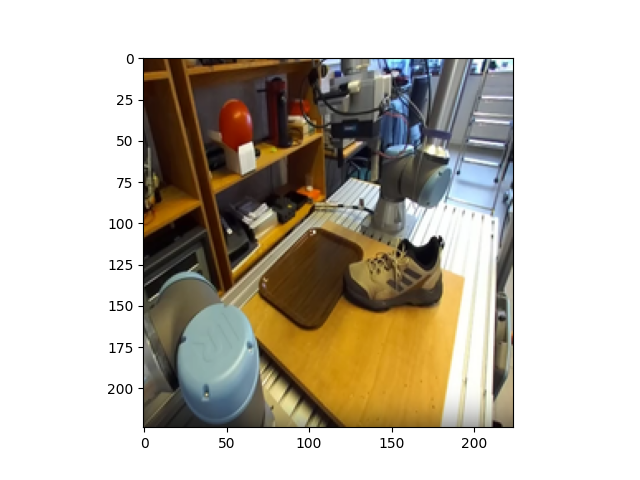

In [63]:
img_coords_1 = []

support_image_id = 0


# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(source_image_pil)

# Connect the 'button_press_event' to the 'onclick' function
cid = fig.canvas.mpl_connect('button_press_event', click_callback(img_coords_1, ax, fig))

# Show the plot
plt.show()

In [51]:
print(img_coords_1)

[]


In [70]:
for i in range(len(img_coords_1)):
    print(img_coords_1[i])

source_vectors = [] 
for i in range(len(img_coords_1)):
    patch_idx = uv_to_patch_idx(img_coords_1[i][0], img_coords_1[i][1], num_patches1, extractor.stride, extractor.p)
    source_vectors.append(source_image_features[0,0,patch_idx])

print(source_vectors)


(178, 115)
(176, 110)
(174, 116)
(177, 121)
(154, 118)
(161, 123)
[tensor([-0.4013,  0.3820, -0.3340,  ...,  0.5657, -0.4528,  0.1101],
       device='cuda:0'), tensor([-0.6583,  0.5524,  0.2800,  ...,  0.0466, -0.7154, -0.0371],
       device='cuda:0'), tensor([-0.8879,  0.5676, -0.5905,  ..., -0.2580, -0.4456, -1.0012],
       device='cuda:0'), tensor([-1.5122, -0.5097,  0.1027,  ...,  3.3971,  0.6504,  0.1143],
       device='cuda:0'), tensor([ 0.2673,  0.2643, -0.7794,  ..., -0.6787,  0.2554,  0.2493],
       device='cuda:0'), tensor([-0.3642,  1.0143, -0.6508,  ...,  0.1654, -1.0215, -1.6437],
       device='cuda:0')]


In [71]:
# find matches

# first do cosine similarity
source_vectors_torch = torch.stack(source_vectors).unsqueeze(0).unsqueeze(0).to(device)
print(source_vectors_torch.shape)
cosine_sim = chunk_cosine_sim(source_vectors_torch,target_image_features)
print(cosine_sim.shape)

# find the top 2 matches
top_matches = torch.topk(cosine_sim,1)
print(top_matches)

# get the patch indices of the top matches
top_matches_indices = top_matches.indices.squeeze(0).squeeze(0)
print(top_matches_indices)

# get the uv coordinates of the top matches
top_matches_uv = [patch_idx_to_uv(top_matches_indices[i], num_patches1, extractor.stride, extractor.p) for i in range(len(top_matches_indices))]
print(top_matches_uv)



torch.Size([1, 1, 6, 3456])
torch.Size([1, 1, 6, 3025])
torch.return_types.topk(
values=tensor([[[[0.3844],
          [0.4896],
          [0.5437],
          [0.5621],
          [0.4449],
          [0.4878]]]], device='cuda:0'),
indices=tensor([[[[1528],
          [1473],
          [1528],
          [1584],
          [1521],
          [1579]]]], device='cuda:0'))
tensor([[1528],
        [1473],
        [1528],
        [1584],
        [1521],
        [1579]], device='cuda:0')
[(176, 112), (176, 108), (176, 112), (180, 116), (148, 112), (160, 116)]


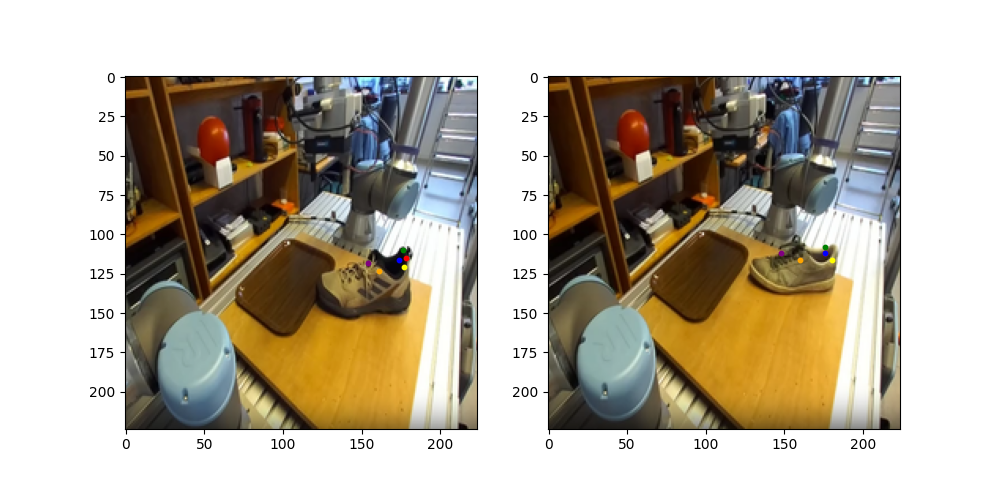

In [72]:
# visualize the top matches next to the source image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(source_image_pil)
ax[1].imshow(target_image_pil)
for i, uv in enumerate(top_matches_uv):
    ax[0].scatter(img_coords_1[i][0], img_coords_1[i][1], c=color_list[i % len(color_list)], s=10)
    ax[1].scatter(uv[0], uv[1], c=color_list[i % len(color_list)], s=10)
plt.show()